# Preprocessing and clustering 3k PBMCs (legacy workflow)

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

## Loading packages

In [25]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

/opt/mambaforge/envs/scspatial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
# Path
data = "/mnt/d12b/SINGLECELL/dataset/PBMC3K/data"
results_file = f'{data}/pbmc3k_scanpy_processed.h5ad'  # the file that will store the analysis results

## Loading data

In [6]:
# Read PBMC3K as an Anndata
adata = ad.read_h5ad(f'{data}'"/pbmc3k_raw.h5ad")

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

normalizing counts per cell
    finished (0:00:00)


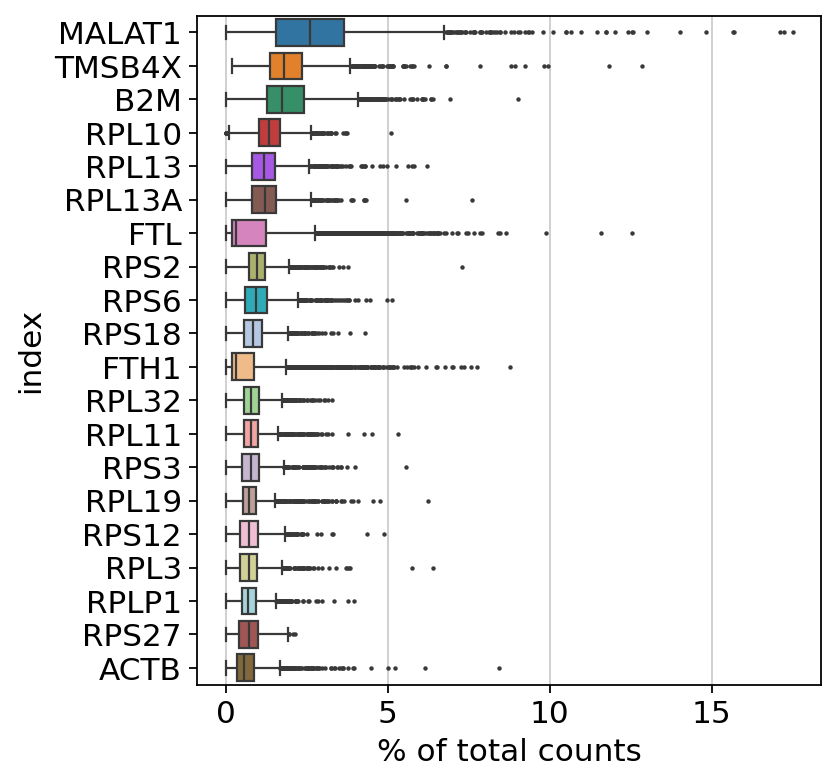

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [13]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [14]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [20]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

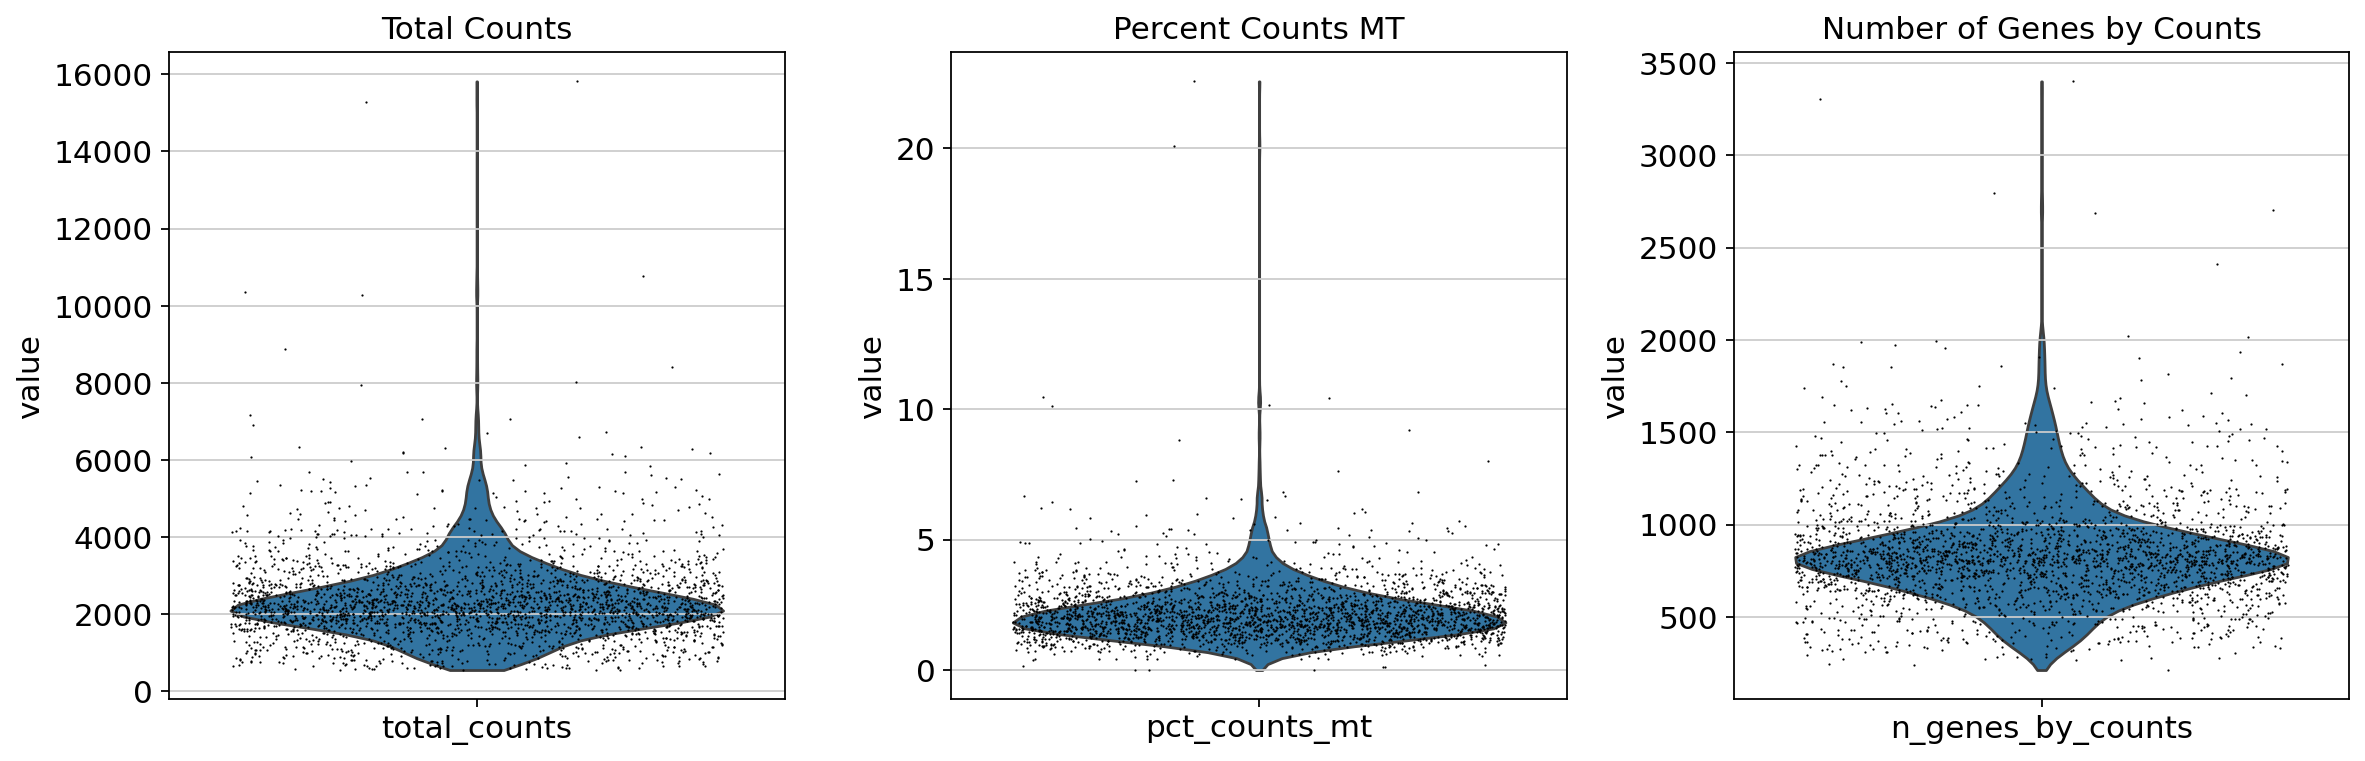

In [36]:
import matplotlib.pyplot as plt
import scanpy as sc

# Create a figure with 3 columns and 1 row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# First plot
sc.pl.violin(adata, "total_counts", jitter=0.4, ax=axs[0], show=False)
axs[0].set_title('Total Counts')

# Second plot
sc.pl.violin(adata, "pct_counts_mt", jitter=0.4, ax=axs[1], show=False)
axs[1].set_title('Percent Counts MT')

# Third plot
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, ax=axs[2], show=False)
axs[2].set_title('Number of Genes by Counts')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


Remove cells that have too many mitochondrial genes expressed or too many total counts:

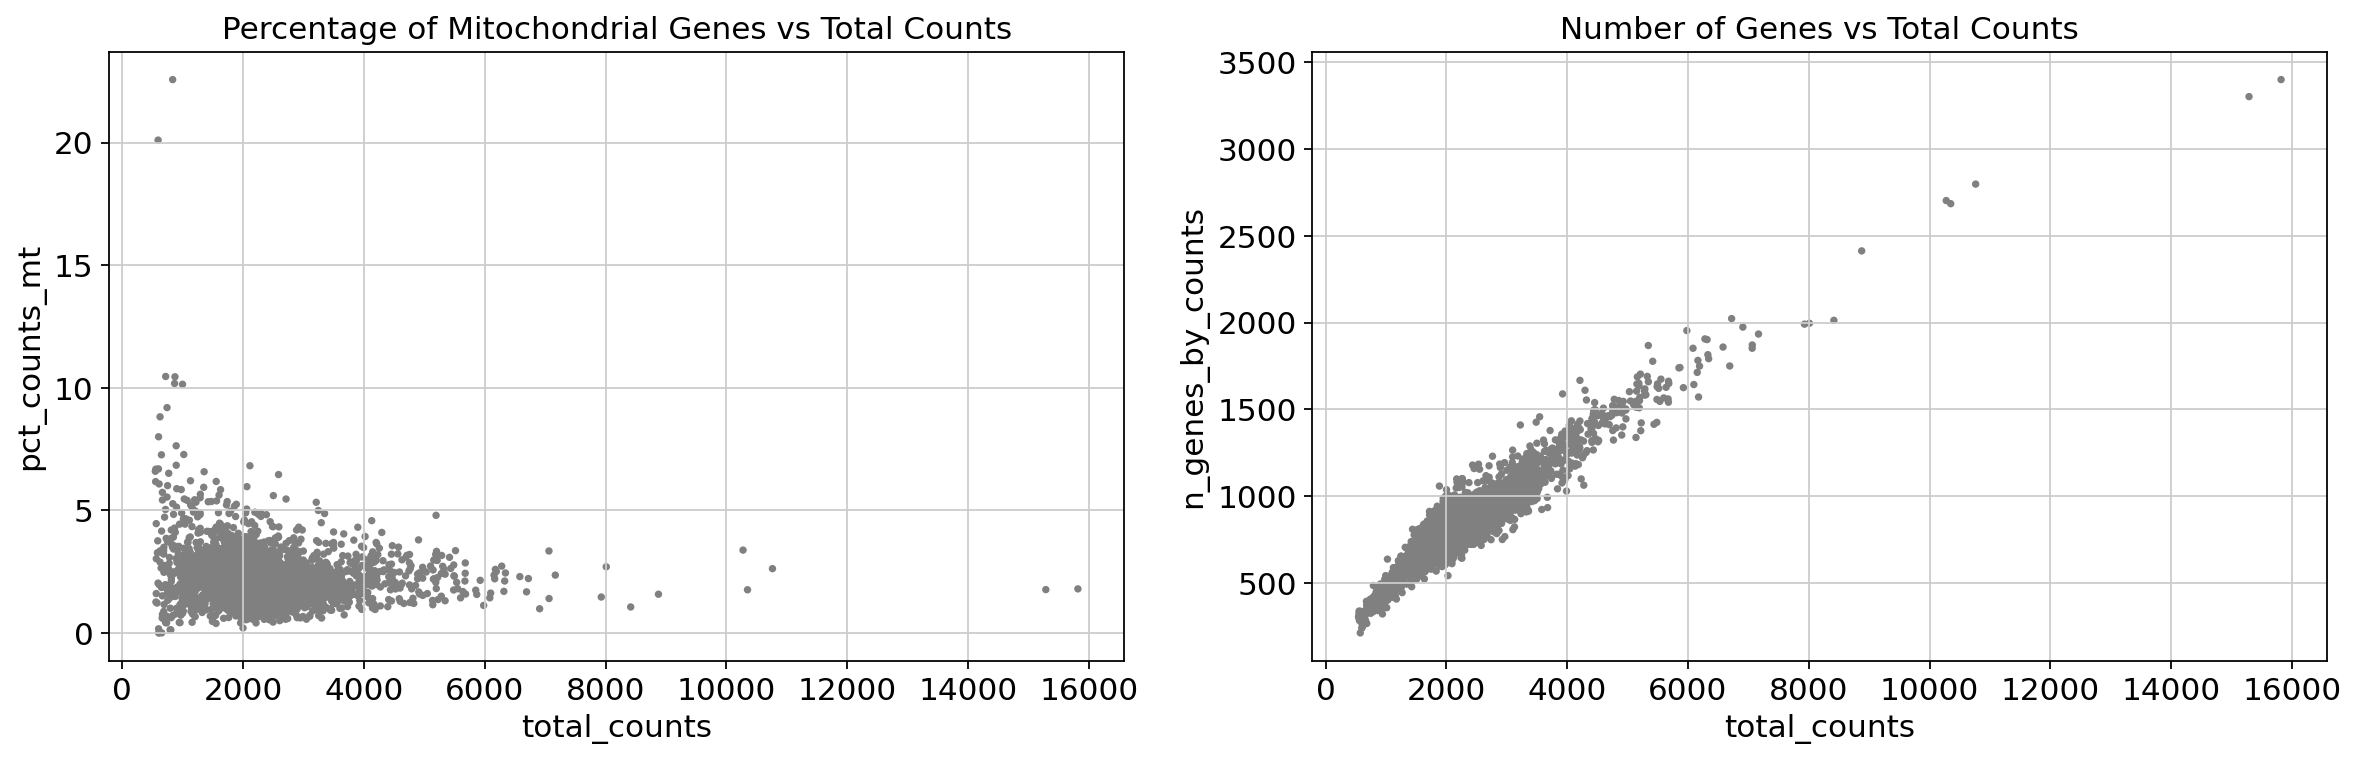

In [43]:
import matplotlib.pyplot as plt
import scanpy as sc

# Create a figure with 2 columns and 1 row
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# First scatter plot
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", ax=axs[0], show=False)
axs[0].set_title('Percentage of Mitochondrial Genes vs Total Counts')

# Second scatter plot
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", ax=axs[1], show=False)
axs[1].set_title('Number of Genes vs Total Counts')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots together
plt.show()


Actually do the filtering by slicing the AnnData object.

In [44]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

Total-count normalize (library-size correct) the data matrix 
 to 10,000 reads per cell, so that counts become comparable among cells.

In [45]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [46]:
sc.pp.log1p(adata)

In [47]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


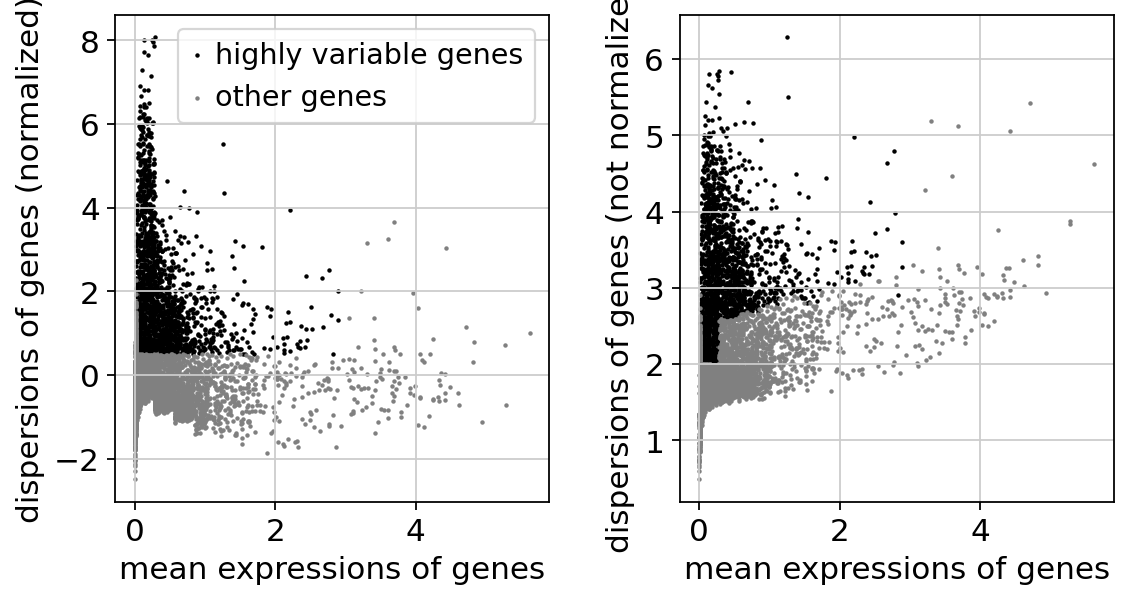

In [48]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [49]:
adata.raw = adata

In [50]:
adata = adata[:, adata.var.highly_variable]

In [51]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [52]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)


In [53]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [54]:
sc.pp.scale(adata, max_value=10)

In [55]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## Principal component analysis

In [56]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


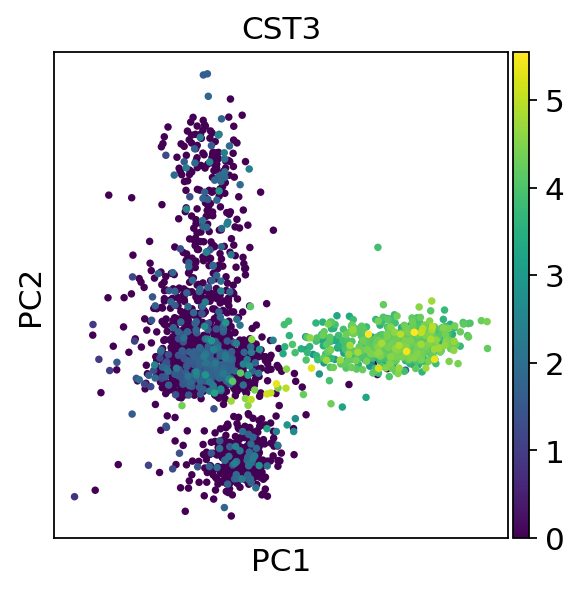

In [59]:
# We can make a scatter plot in the PCA coordinates, but we will not use that later on.
sc.pl.pca(adata, color="CST3")

#### inspect the contribution of single PCs to the total variance in the data

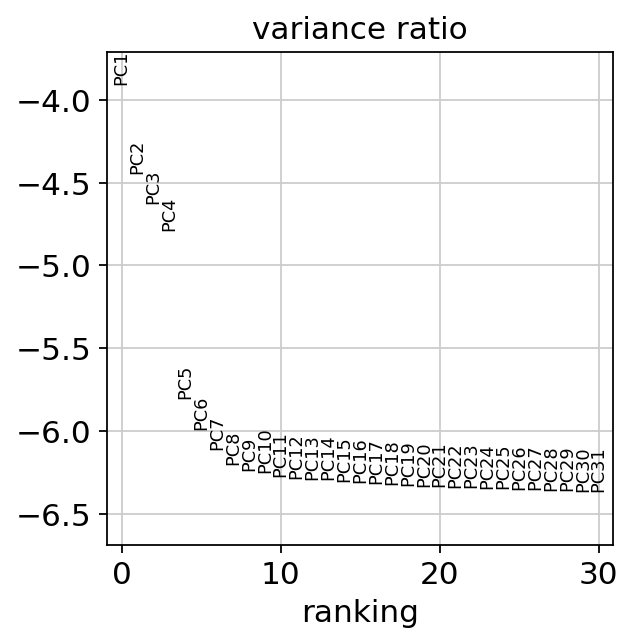

In [60]:
sc.pl.pca_variance_ratio(adata, log=True)

In [65]:
adata.write(results_file)

In [69]:
adata.varm['PCs']

array([[-2.60148402e-02,  3.25416983e-03,  1.89788605e-03, ...,
        -5.15307719e-03,  1.45224724e-02, -6.66973996e-04],
       [-8.27821810e-03,  9.08316858e-03, -7.81428826e-04, ...,
         3.08497138e-02, -8.94393865e-03, -2.88247620e-03],
       [-3.31518659e-03,  3.20968614e-03,  2.79852509e-04, ...,
         1.01443771e-02, -5.54267142e-04,  1.50904048e-03],
       ...,
       [ 8.34176689e-03, -1.24652486e-03, -4.12194617e-03, ...,
        -1.01629226e-02,  9.25791450e-03,  2.79668253e-02],
       [-1.64065193e-02,  4.41014133e-02, -2.14161864e-05, ...,
         9.97361168e-03, -4.53842711e-03, -1.36539685e-02],
       [-1.51882377e-02,  4.00087088e-02,  5.41213853e-03, ...,
        -3.67074320e-03,  2.11187340e-02,  3.59666459e-02]])

## Computing the neighborhood graph

In [67]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

In [74]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    #flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [75]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [76]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


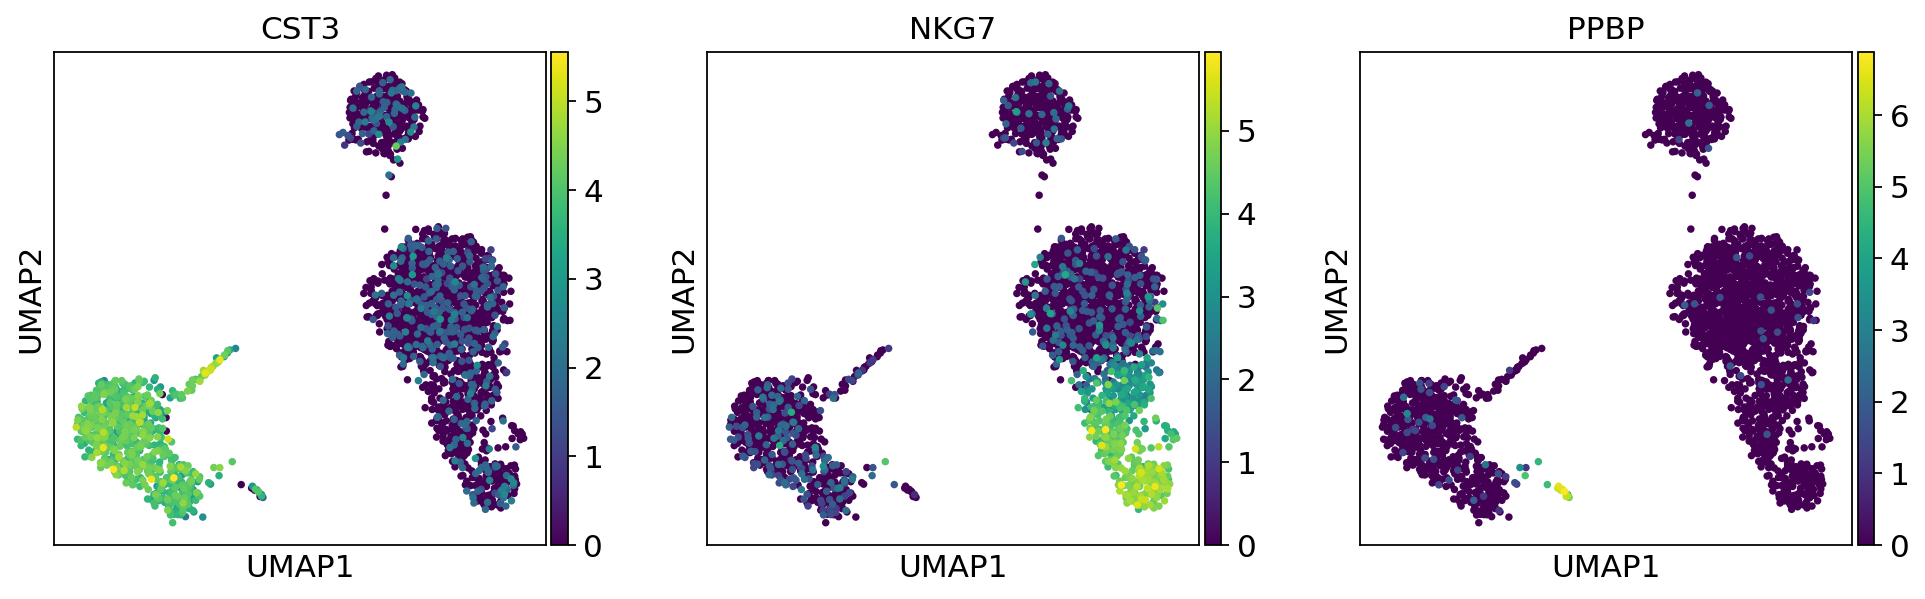

In [77]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

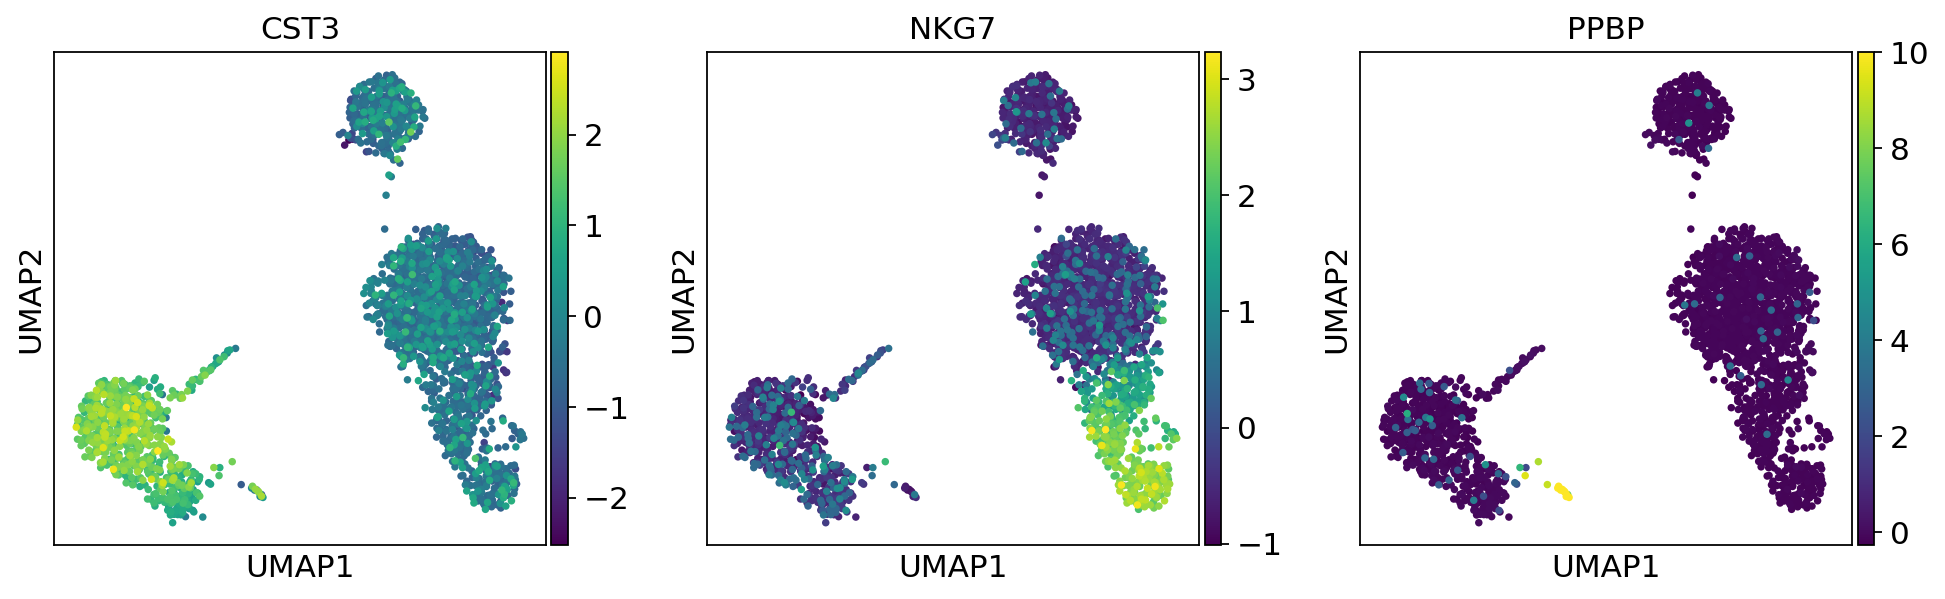

In [78]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

## Clustering the neighborhood graph

In [81]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    #flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


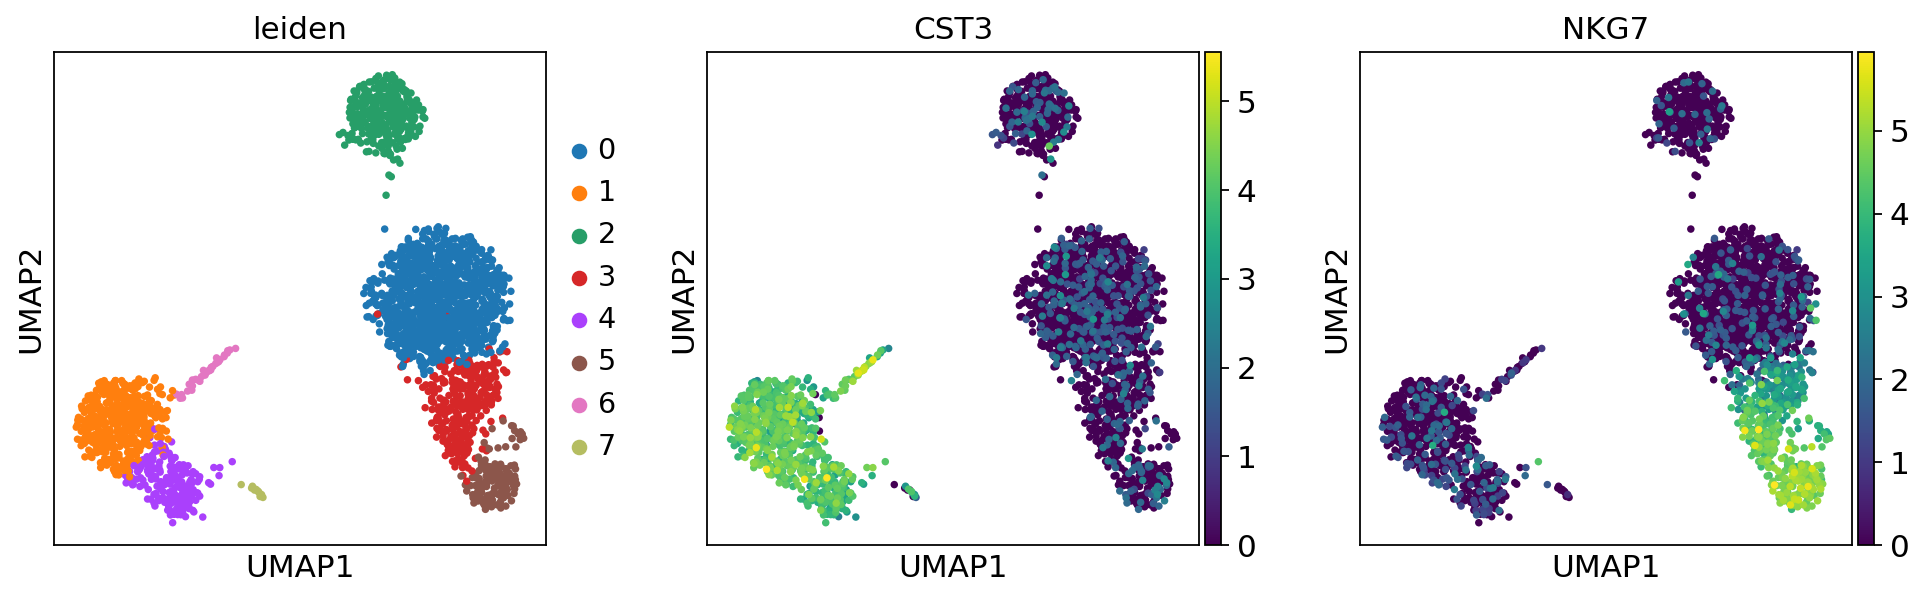

In [82]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [87]:
adata.write(results_file)

## Finding marker genes